# Tutorial: Intrinsic dimension

## Two NN estimator 

### Datasets

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_68274/2525045166.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, rect = [0.23, 0.05, 0.44, 0.8])
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_68274/2525045166.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, rect = [0.5, 0., 0.71, 1.])
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_68274/2525045166.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, rect = [0.73, 0.05, 0.94, 0.8])


Text(0.74, 0.78, 'd')

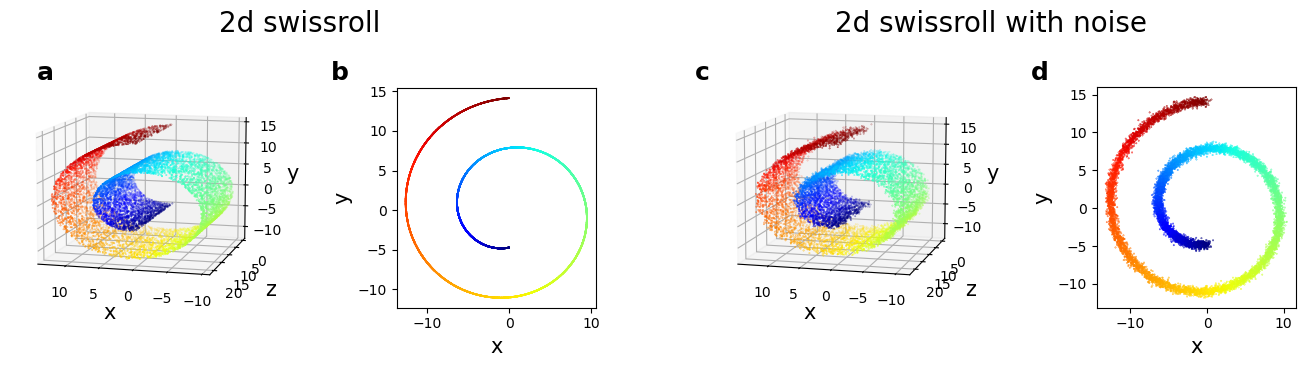

In [35]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

n_samples = 10000
std_noise = 0.3
X, t = make_swiss_roll(n_samples, noise=0.)
X_noisy, t_noisy = make_swiss_roll(n_samples, noise=std_noise)


fig = plt.figure(figsize = (14,4))

gs = GridSpec(1,1)
ax = fig.add_subplot(gs[0], projection = '3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s = 0.1, c=t, cmap= 'jet')
ax.set_xlabel('x', fontsize = 15)
ax.set_ylabel('z', fontsize = 15)
ax.set_zlabel('y', fontsize = 15)
ax.view_init(10, 105)
gs.tight_layout(fig, rect = [0.0, 0.0, 0.21, 1])

gs = GridSpec(1,1)
ax = fig.add_subplot(gs[0])
ax.scatter(-X[:, 0], X[:, 2], s = 0.1, c=t, cmap= 'jet')
ax.set_xlabel('x', fontsize = 15)
ax.set_ylabel('y', fontsize = 15)
gs.tight_layout(fig, rect = [0.23, 0.05, 0.44, 0.8])


gs = GridSpec(1,1)
ax = fig.add_subplot(gs[0], projection = '3d')
ax.scatter(X_noisy[:, 0], X_noisy[:, 1], X_noisy[:, 2], s = 0.1, c=t_noisy, cmap= 'jet')
ax.set_xlabel('x', fontsize = 15)
ax.set_ylabel('z', fontsize = 15)
ax.set_zlabel('y', fontsize = 15)
ax.view_init(10, 105)
gs.tight_layout(fig, rect = [0.5, 0., 0.71, 1.])

gs = GridSpec(1,1)
ax = fig.add_subplot(gs[0])
ax.scatter(-X_noisy[:, 0], X_noisy[:, 2], s = 0.1, c=t_noisy, cmap= 'jet')
ax.set_xlabel('x', fontsize = 15)
ax.set_ylabel('y', fontsize = 15)
gs.tight_layout(fig, rect = [0.73, 0.05, 0.94, 0.8])

fig.text(0.16, 0.9, '2d swissroll', fontsize = 20)
fig.text(0.6, 0.9, '2d swissroll with noise', fontsize = 20)

fig.text(0.03, 0.78, 'a', fontsize = 18, weight = 'bold')
fig.text(0.24, 0.78, 'b', fontsize = 18, weight = 'bold')
fig.text(0.5, 0.78, 'c', fontsize = 18, weight = 'bold')
fig.text(0.74, 0.78, 'd', fontsize = 18, weight = 'bold')

### Estimating the intrinsic dimension with twoNN

In [36]:
from dadapy import data
# initialise the Data class
_data = data.Data(X)
# estimate ID
id_twoNN, _, r = _data.compute_id_2NN()


# initialise the Data class noisy dataset
_data = data.Data(X_noisy)
# estimate ID
id_twoNN_noisy, _, r_noisy = _data.compute_id_2NN()

#
#_data = data.Data(X_plane)
#id_gride, _, r_gride = _data.return_id_scaling_gride(range_max = 5000)
#id_decimation, err, r_decimation = _data.return_id_scaling_2NN(N_min= 20)

/Users/aldoglielmo/DRTA_code/DADApy_all/DADApy/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(
/Users/aldoglielmo/DRTA_code/DADApy_all/DADApy/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(


### Results and comments

##### Legend

* __ID__: intrinisc dimensions given at output from 'compute_id_2NN'

* __N__: total number of datapoints

* __$r_{1i}$__ : distance between point $i$ and its first neighbor

* __$r_{2i}$__ : distance between point $i$ and its second neighbor

* __r__ (typical distance): $\frac{1}{N} \sum \limits_{i=1}^{N} \frac{r_{1i}+r_{2i}}{2}$ 



In [37]:
print(f'ID = {id_twoNN}; r = {r}'.format(id_twoNN, r))
print(f'ID_noisy = {id_twoNN_noisy}; r_noisy = {r_noisy}; '.format(id_twoNN_noisy, r_noisy))

ID = [1.99]; r = 0.26886521906315913
ID_noisy = [2.96]; r_noisy = 0.40519267975371304; 


The ID of the noiseless swissroll is comparable to the true ID ($\sim 2$). The typical distance __$r$__ is much smaller the the dimension of the manifold ($\sim 20$, see fig. a)

Adding a gaussian noise to the data with standard deviation $\sigma=0.3$ (see fig. c, d) the ID increases to reach almost 3. 

In this case, the typical distance __$r_{noisy}$__ between the first two neighbors is of the same order of $\sigma$. The twoNN estimator can not distinguish the 'noise' direction from the two relevant directions tangent the data manifold (also named *soft directions*). 

To identify the 'correct' intrinsic dimension we need to increase the neighborhood range. In the next part of the tutorial we show two solutions to address this challenge.

## Analysis of the ID of noisy datasets: twoNN vs gride

### Synthetic datasets: noisy plane, noisy spirals

/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_68274/1685459742.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, rect = [0.4, 0., 0.65, 1])
/var/folders/c2/kglcjml916z_xncfbyv74pn80000gn/T/ipykernel_68274/1685459742.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, rect = [0.7, 0.0, 0.95, 1.])


Text(0.7, 0.78, 'c')

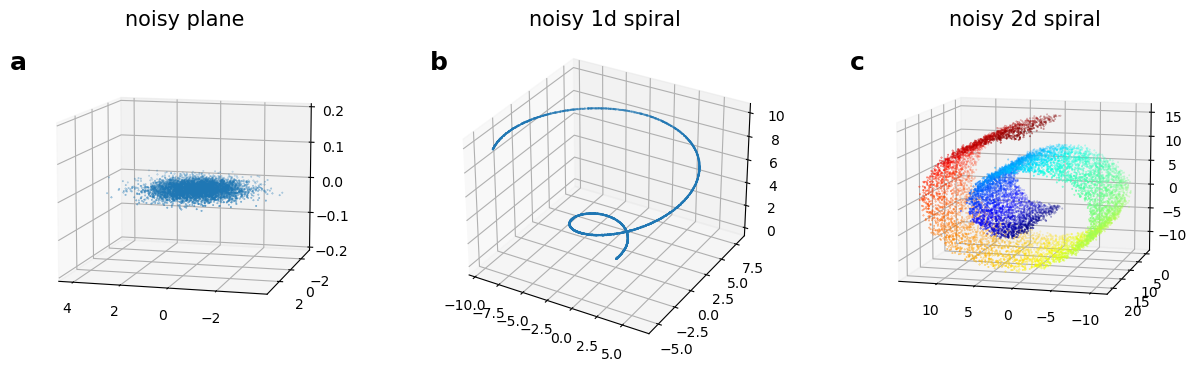

In [38]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec


#2d plane with noise embedded in 3d
ndata = 5000
noise_plane = 0.01
X = np.random.normal(size = (ndata, 2))
X_plane = np.random.normal(scale = noise_plane , size = (ndata, 3))
X_plane[:, :2] = X

#1d spiral with noise embedded in 3d
ndata = 5000
noise1 = 0.05
t = np.random.uniform(0,10, ndata)
spiral1 = np.array([t*np.cos(t), t*np.sin(t), t]).T + noise1*np.random.rand(ndata, 3)

#2d spiral with noise embedded in 3d
n_samples = 10000
noise2 = 0.3
spiral2, t = make_swiss_roll(n_samples, noise=noise2)
#*******************************************************************************************************

#plot
fig = plt.figure(figsize = (14, 4))
gs = GridSpec(1,1)

ax = fig.add_subplot(gs[0], projection = '3d')
ax.scatter(X_plane[:, 0], X_plane[:, 1], X_plane[:, 2], s = 0.1)
ax.set_zlim(-0.2, 0.2)
ax.set_title('noisy plane', fontsize = 15)
ax.view_init(10, 105)
gs.tight_layout(fig, rect = [0.1, 0.0, .35 ,1])


gs = GridSpec(1,1)
ax = fig.add_subplot(gs[0], projection = '3d')
ax.scatter(spiral1[:, 0], spiral1[:, 1], spiral1[:, 2], s = 0.1)
ax.set_title('noisy 1d spiral', fontsize = 15)
gs.tight_layout(fig, rect = [0.4, 0., 0.65, 1])

gs = GridSpec(1,1)
ax = fig.add_subplot(gs[0], projection = '3d')
ax.scatter(spiral2[:, 0], spiral2[:, 1], spiral2[:, 2], s = 0.1, c= t, cmap = 'jet')
ax.set_title('noisy 2d spiral', fontsize = 15)
ax.view_init(10, 105)
gs.tight_layout(fig, rect = [0.7, 0.0, 0.95, 1.])

fig.text(0.1, 0.78, 'a', fontsize = 18, weight = 'bold')
fig.text(0.4, 0.78, 'b', fontsize = 18, weight = 'bold')
fig.text(0.7, 0.78, 'c', fontsize = 18, weight = 'bold')

### Id computation

In [39]:
from dadapy import data
def compute_ids_scaling(X, range_max = 2048, N_min = 20):
    "instantiate data class"
    _data = data.Data(coordinates = X, 
                     maxk = 100)
    "compute ids scaling gride"
    ids_gride, ids_err_gride, rs_gride = _data.return_id_scaling_gride(range_max=range_max)
    "compute ids with twoNN + decimation"
    ids_twoNN, ids_err_twoNN, rs_twoNN = _data.return_id_scaling_2NN(N_min = N_min)
    return ids_gride, ids_twoNN, rs_gride, rs_twoNN

#*************************************************************

ids_plane_gride, ids_plane_twoNN, rs_plane_gride, rs_plane_twoNN = compute_ids_scaling(
                                                                            X_plane, 
                                                                            range_max = X_plane.shape[0]-1, 
                                                                            N_min = 20
                                                                            )

ids_spiral1_gride, ids_spiral1_twoNN, rs_spiral1_gride, rs_spiral1_twoNN = compute_ids_scaling(
                                                                            spiral1, 
                                                                            range_max = spiral1.shape[0]-1, 
                                                                            N_min = 20
                                                                            )

ids_spiral2_gride, ids_spiral2_twoNN, rs_spiral2_gride, rs_spiral2_twoNN = compute_ids_scaling(
                                                                            spiral2, 
                                                                            range_max = (spiral2.shape[0]-1)//4, 
                                                                            N_min = 20
                                                                            )

/Users/aldoglielmo/DRTA_code/DADApy_all/DADApy/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(
/Users/aldoglielmo/DRTA_code/DADApy_all/DADApy/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(
/Users/aldoglielmo/DRTA_code/DADApy_all/DADApy/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(


### Results and comments

/Users/aldoglielmo/miniconda3/envs/dadapy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aldoglielmo/miniconda3/envs/dadapy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aldoglielmo/miniconda3/envs/dadapy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aldoglielmo/miniconda3/envs/dadapy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

Text(0.63, 0.9, 'd')

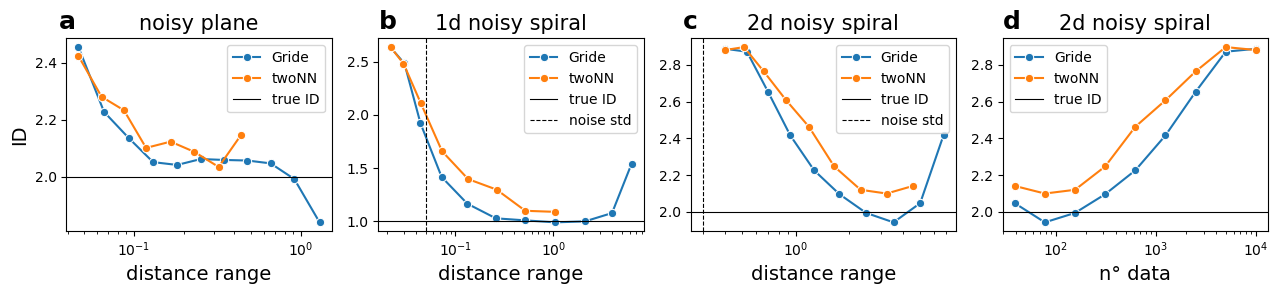

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (16, 3))
gs = GridSpec(1,5)

ax = fig.add_subplot(gs[0])
xrange = min(len(ids_plane_gride), len(ids_plane_twoNN))
sns.lineplot(ax = ax, x=rs_plane_gride, y = ids_plane_gride, label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=rs_plane_twoNN, y = ids_plane_twoNN, label = 'twoNN', marker = 'o')
ax.set_xscale('log')
ax.set_title('noisy plane', fontsize = 15)
ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('distance range', fontsize = 14)
ax.axhline(2, color = 'black', alpha = 1, label = 'true ID', linewidth = 0.8)
#ax.axvline(noise_plane, color = 'black', alpha = 1, label = 'noise scale', linewidth = 0.8, linestyle= 'dotted')
ax.legend(fontsize = 10)

ax = fig.add_subplot(gs[1])
xrange = min(len(ids_spiral1_gride), len(ids_spiral1_twoNN))
sns.lineplot(ax = ax, x=rs_spiral1_gride, y = ids_spiral1_gride, label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=rs_spiral1_twoNN, y = ids_spiral1_twoNN, label = 'twoNN', marker = 'o')
ax.set_xscale('log')
ax.set_title('1d noisy spiral', fontsize = 15)
ax.set_xlabel('distance range', fontsize = 14)
ax.axhline(1, color = 'black', alpha = 1, label = 'true ID', linewidth = 0.8)
ax.axvline(noise1, color = 'black', alpha = 1, label = 'noise std', linewidth = 0.8, linestyle= 'dashed')
ax.legend(fontsize = 10)
gs.tight_layout(fig)


ax = fig.add_subplot(gs[2])
xrange = min(len(ids_spiral2_gride), len(ids_spiral2_twoNN))
sns.lineplot(ax = ax, x=rs_spiral2_gride, y = ids_spiral2_gride, label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=rs_spiral2_twoNN, y = ids_spiral2_twoNN, label = 'twoNN', marker = 'o')
ax.set_xscale('log')
ax.set_title('2d noisy spiral', fontsize = 15)
ax.set_xlabel('distance range', fontsize = 14)
ax.axhline(2, color = 'black', alpha = 1, label = 'true ID', linewidth = 0.8)
ax.axvline(noise2, color = 'black', alpha = 1, label = 'noise std', linewidth = 0.8, linestyle= 'dashed')
ax.legend(fontsize = 10)
gs.tight_layout(fig)


ax = fig.add_subplot(gs[3])
xrange = min(len(ids_spiral2_gride), len(ids_spiral2_twoNN))
x = spiral2.shape[0]/np.array([2**i for i in range(xrange)])
sns.lineplot(ax = ax, x=x, y = ids_spiral2_gride[:xrange], label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=x, y = ids_spiral2_twoNN[:xrange], label = 'twoNN', marker = 'o')
ax.legend(fontsize = 10)
ax.set_xscale('log')
ax.set_title('2d noisy spiral', fontsize = 15)
ax.set_xlabel('n° data', fontsize = 14)
#ax.set_xticks(x, x[::-1])
ax.axhline(2, color = 'black', alpha = 1, label = 'true ID', linewidth = 0.8)
ax.legend(fontsize = 10)


fig.text(0.04, 0.9, 'a', fontsize = 18, weight = 'bold')
fig.text(0.24, 0.9, 'b', fontsize = 18, weight = 'bold')
fig.text(0.43, 0.9, 'c', fontsize = 18, weight = 'bold')
fig.text(0.63, 0.9, 'd', fontsize = 18, weight = 'bold')

The variance of the *noise* directions are is much smaller than size of the manifold. For example, in our syntetic datasets (fig. a, b, c-d) the noise standard deviation is few percents of size of the dataset.

When the typical distance involved in the ID estimate becomes larger than the noise scale (but sufficilently smaller than the size of the dataset) the intrinsic dimension approaces a value consistent with the number of *soft* directions of the data. If the noise variance is much smaller from than the variance of the data, the ID as a function of the typical distance exhibits a plateau. 

To identify the **ID** we look for **plateaus** in the plot the **ID vs scale**. 

###### Strategies to increase the scale

**TwoNN**: increases the typical distance by bootstrapping random subsets of data, and measures the ID on such subsets with progressively fewer datapoints. The typical distance for a random subset of $N^*$ points is:

 r = $\frac{1}{N_{dec}} \sum \limits_{i=1}^{N_{dec}} \frac{r_{1i}+r_{2i}}{2}$ 

this is what is plotted on the x axis for the TwoNN estimator (Fig. **a**, **b**, **c** ).


**Gride**: increases the typical distance by considering neighbors of higher order and measures the ID on the full dataset. The typical distance considering neighbors of order n and 2n is:

 $r_n = \frac{1}{N} \sum \limits_{i=1}^{N} \frac{r_{n_i}+r_{2n_i}}{2}$
 
the average is taken over all the N datapoints. This is what is plotted on the x axis for the Gride estimator (Fig. **a**, **b**, **c** ).

## Scale analysis when the intrinsic dimension is high

When the ID is high (say, ID>5-10) the concentration of measure makes all the distances comparable. To analyze how the ID varies with the scale we plot (see Fig. d):

###### Rule 1
* *__IDs vs N/n1__ for the __Gride__ estimator;* 
* *__IDs vs N_dec__ for the __twoNN__ estimator* 

where:

* __n1__: order of the first neighbors involved in the gride estimate. They are n1 = [1, 2, 4, 8, ..., log2(range_scaling)] and $n2 = 2 \cdot n1$ 

* __N_dec__ (twoNN): size of the decimated dataset. It is N/[1, 2, 4, 8, ...] up to N_min

*We typically plot the x axis in logarithmic scale.*


The constant factor N in N/n1 (Gride estimator), makes the x-axis easy to compare with the twoNN estimator. Indeed, the average distances used by Gride for n1=2 (n2=4) is comparable to that of the twoNN estimator evaluated on half of the datapoints see Fig. **d**.

We also notice that when the ID is small __rule1__ is equivalent to the more intuitive plot IDs vs average distance (compare Figs. c and d). 

### Real datastes: mnist, isomap faces, isolet voices

isomap_faces shape: N data x P features = (698, 4096)
isolet shape: N data x P features = (7797, 617)
mnist 1 digit shape: N data x P features = (6742, 784)


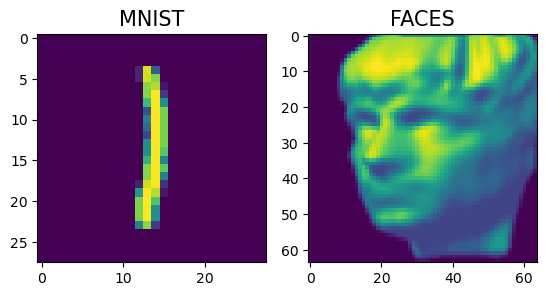

In [41]:
from urllib.request import urlretrieve
from collections import namedtuple
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np

def fetch_data(data_path, data_url, force_download = True):
    if not exists(data_path) or force_download:
        print(f"downloading data from {data_url} to {data_path}")
        urlretrieve(data_url, data_path)
        dataset = np.load(data_path)
    else:
        dataset = np.load(data_path)
    return dataset

#mnist and isolet datasets
RemoteFileMetadata = namedtuple("RemoteFileMetadata", ["filename", "url"])
isolet = RemoteFileMetadata(filename= 'isolet_float32.npy', url='https://figshare.com/ndownloader/files/34882686')
mnist = RemoteFileMetadata(filename= 'mnist.npy', url= 'https://figshare.com/ndownloader/files/34882689')
faces = RemoteFileMetadata(filename= 'isomap_faces.npy', url= 'https://figshare.com/ndownloader/files/34894287')

faces_data = fetch_data(f'./datasets/{faces.filename}', faces.url, force_download = False)
print(f'isomap_faces shape: N data x P features = {faces_data.shape}')

isolet_data = fetch_data(f'./datasets/{isolet.filename}', isolet.url, force_download = False)
print(f'isolet shape: N data x P features = {isolet_data.shape}')

mnist_data = fetch_data(f'./datasets/{mnist.filename}', mnist.url, force_download = False)
mnist_data = mnist_data.astype('float')
print(f'mnist 1 digit shape: N data x P features = {mnist_data.shape}')

#************************************************************************************************
#plot
fig = plt.figure(figsize = (8, 3))
gs = GridSpec(1,3)

ax = fig.add_subplot(gs[1])
ax.imshow(mnist_data[10].reshape(28, 28))
ax.set_title('MNIST', fontsize = 15)

ax = fig.add_subplot(gs[2])
ax.imshow(faces_data[0].reshape(64, 64).T)
ax.set_title('FACES', fontsize = 15)

gs.tight_layout(fig)

### ID computation
###### This may take up to 20/30 seconds

In [42]:
from dadapy import data
def compute_ids_scaling(X, range_max = 2048, N_min = 20):
    "instantiate data class"
    _data = data.Data(coordinates = X, 
                     maxk = 100)
    "compute ids scaling gride"
    ids_gride, ids_err_gride, rs_gride = _data.return_id_scaling_gride(range_max=range_max)
    "compute ids with twoNN + decimation"
    ids_twoNN, ids_err_twoNN, rs_twoNN = _data.return_id_scaling_2NN(N_min = N_min)
    return ids_gride, ids_twoNN, rs_gride, rs_twoNN


"this may take from 10 to 20 seconds"
ids_mnist_gride, ids_mnist_twoNN, _, _ =  compute_ids_scaling(mnist_data, range_max = 2048, N_min = 20)
ids_faces_gride, ids_faces_twoNN, _, _ = compute_ids_scaling(faces_data, range_max = 2048, N_min = 20)
ids_isolet_gride, ids_isolet_twoNN, _, _ = compute_ids_scaling(isolet_data, range_max = 2048, N_min = 20)

/Users/aldoglielmo/DRTA_code/DADApy_all/DADApy/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(
/Users/aldoglielmo/DRTA_code/DADApy_all/DADApy/dadapy/metric_comparisons.py:60: UserWarning: data type is float64: most methods work only with float-type inputs
  super().__init__(


### Results and comments

/Users/aldoglielmo/miniconda3/envs/dadapy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aldoglielmo/miniconda3/envs/dadapy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aldoglielmo/miniconda3/envs/dadapy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/aldoglielmo/miniconda3/envs/dadapy311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

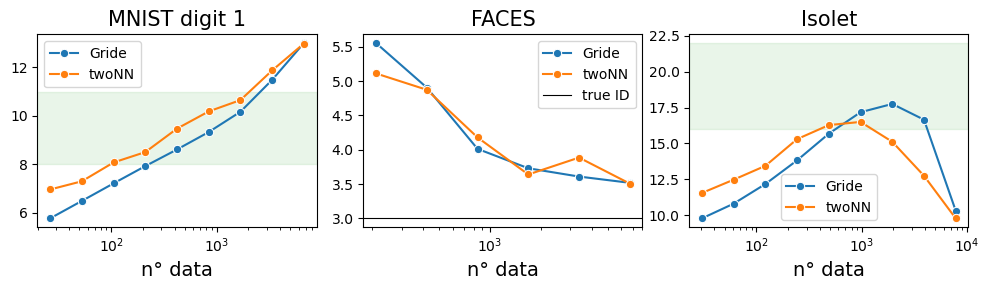

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (10, 3))
gs = GridSpec(1,3)

ax = fig.add_subplot(gs[0])
xrange = min(len(ids_mnist_gride), len(ids_mnist_twoNN))
x = mnist_data.shape[0]/np.array([2**i for i in range(xrange)])
sns.lineplot(ax = ax, x=x, y = ids_mnist_gride[:xrange], label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=x, y = ids_mnist_twoNN[:xrange], label = 'twoNN', marker = 'o')
ax.legend(fontsize = 10)
ax.set_xscale('log')
ax.set_title('MNIST digit 1', fontsize = 15)
#ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('n° data', fontsize = 14)
ax.axhspan(8, 11, color = 'C2', alpha = 0.1)

ax = fig.add_subplot(gs[1])
xrange = min(len(ids_faces_gride), len(ids_faces_twoNN))
x = mnist_data.shape[0]/np.array([2**i for i in range(xrange)])
sns.lineplot(ax = ax, x=x, y = ids_faces_gride[:xrange], label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=x, y = ids_faces_twoNN[:xrange], label = 'twoNN', marker = 'o')
ax.set_xscale('log')
ax.set_title('FACES', fontsize = 15)
#ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('n° data', fontsize = 14)
ax.axhline(3, color = 'black', label = 'true ID', linewidth = 0.8)
ax.legend(fontsize = 10)


ax = fig.add_subplot(gs[2])
xrange = min(len(ids_isolet_gride), len(ids_isolet_twoNN))
x = isolet_data.shape[0]/np.array([2**i for i in range(xrange)])
sns.lineplot(ax = ax, x=x, y = ids_isolet_gride[:xrange], label = 'Gride', marker = 'o')
sns.lineplot(ax = ax, x=x, y = ids_isolet_twoNN[:xrange], label = 'twoNN', marker = 'o')
ax.legend(fontsize = 10)
ax.set_xscale('log')
ax.set_title('Isolet', fontsize = 15)
#ax.set_ylabel('ID', fontsize = 14)
ax.set_xlabel('n° data', fontsize = 14)
ax.axhspan(16, 22, color = 'C2', alpha = 0.1)

gs.tight_layout(fig)

When the ID is high the concentration of measure makes all the distances comparable and __rule1__ becomes the only sensible way to go. 
The ground truth ID for these datasets is not known, but there is a (debatable) consensus for the plausible range of IDs of each of them. This range is highlighted in the figures. 
The plateau for the MNIST dataset Fig. c is absent, for the face dataset is around 3.5/3.6, for the isolet dataset is around 17.5 for Gride, 16 for twoNN. 

When the plateau is absent we typically choose as ID the Gride estimate with (n1=2, n2=4), or (n1=4, n2=8), or an average of these.